In [ ]:
!nvidia-smi

Fri Feb 20 15:03:57 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%%writefile lab1.cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <stdio.h>
#include <math.h>

#define N (1024*1024)

__global__ void kernel ( float * data )
{
   int   idx = blockIdx.x * blockDim.x + threadIdx.x;

   if (idx < N)
   {
       float x   = 2.0f * 3.1415926f * (float) idx / (float) N;
       data [idx] = sinf ( sqrtf ( x ) );
   }
}

int main(int argc, char *argv[])
{
    // Получение информации об устройстве
    int deviceCount;
    cudaGetDeviceCount(&deviceCount);
    printf("Found %d device(s)\n\n", deviceCount);

    cudaDeviceProp prop;
    cudaGetDeviceProperties(&prop, 0);

    printf("Device name: %s\n", prop.name);
    printf("Compute capability: %d.%d\n", prop.major, prop.minor);
    printf("Multiprocessors: %d\n", prop.multiProcessorCount);
    printf("Global memory: %llu MB\n\n",
           prop.totalGlobalMem / (1024ULL*1024ULL));

    float *  a = (float*)malloc(N * sizeof(float));
    float * dev = nullptr;

    // выделить память на GPU
    cudaMalloc ( (void**)&dev, N * sizeof ( float ) );

    // конфигурация запуска N нитей (строго по методичке: 512 потоков в блоке)
    int threads = 512;

    // число блоков не меньше числа мультипроцессоров
    int blocks = (N/512);
    if (blocks < prop.multiProcessorCount)
        blocks = prop.multiProcessorCount;

    printf("Threads per block: %d\n", threads);
    printf("Blocks: %d\n\n", blocks);

    // замер времени выполнения
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    kernel<<<dim3(blocks,1), dim3(threads,1)>>>(dev);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time;
    cudaEventElapsedTime(&time, start, stop);

    printf("Execution time: %f ms\n\n", time);

    // скопировать результаты в память CPU
    cudaMemcpy ( a, dev, N * sizeof ( float ), cudaMemcpyDeviceToHost );

    // освободить выделенную память
    cudaFree   ( dev );
    free(a);

    return 0;
}

Overwriting lab1.cu


In [ ]:
!nvcc lab1.cu -o lab1

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [ ]:
!./lab1

Found 1 device(s)

Device name: Tesla T4
Compute capability: 7.5
Multiprocessors: 40
Global memory: 14912 MB

Threads per block: 512
Blocks: 2048

Execution time: 0.418560 ms



In [ ]:
%%writefile vector_mul.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <time.h>

__global__ void vectorMul(int* A, int* B, int* C, int n)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n)
        C[idx] = A[idx] * B[idx];
}

int main(int argc, char** argv)
{
    if (argc < 2)
    {
        printf("Usage: ./vector_mul <shift>\n");
        return 1;
    }

    int shift = atoi(argv[1]);
    int N = 1 << shift;

    size_t size = N * sizeof(int);

    int *A = (int*)malloc(size);
    int *B = (int*)malloc(size);
    int *C_gpu = (int*)malloc(size);

    srand(42);

    for (int i = 0; i < N; i++)
    {
        A[i] = rand() % 100 + 1;
        B[i] = rand() % 100 + 1;
    }

    int *devA, *devB, *devC;
    cudaMalloc((void**)&devA, size);
    cudaMalloc((void**)&devB, size);
    cudaMalloc((void**)&devC, size);

    cudaMemcpy(devA, A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(devB, B, size, cudaMemcpyHostToDevice);

    dim3 threads(256);
    dim3 blocks((N + 255) / 256);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    vectorMul<<<blocks, threads>>>(devA, devB, devC, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float time_gpu;
    cudaEventElapsedTime(&time_gpu, start, stop);

    cudaMemcpy(C_gpu, devC, size, cudaMemcpyDeviceToHost);

    // Проверка
    int errors = 0;
    for (int i = 0; i < N; i++)
        if (C_gpu[i] != A[i] * B[i])
            errors++;

    printf("====================================================\n");
    printf("Shift            : %d\n", shift);
    printf("Vector size (N)  : %d\n", N);
    printf("Threads per block: 256\n");
    printf("Blocks           : %d\n", blocks.x);
    printf("Execution time   : %.6f ms\n", time_gpu);
    printf("Verification     : %s\n", (errors == 0) ? "SUCCESS" : "FAILED");
    printf("====================================================\n\n");

    cudaFree(devA);
    cudaFree(devB);
    cudaFree(devC);

    free(A);
    free(B);
    free(C_gpu);

    return 0;
}

Overwriting vector_mul.cu


In [ ]:
!nvcc vector_mul.cu -o vector_mul

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [ ]:
!./vector_mul 16
!./vector_mul 17
!./vector_mul 18
!./vector_mul 19
!./vector_mul 20
!./vector_mul 21


Shift            : 16
Vector size (N)  : 65536
Threads per block: 256
Blocks           : 256
Execution time   : 11.804576 ms
Verification     : SUCCESS

Shift            : 17
Vector size (N)  : 131072
Threads per block: 256
Blocks           : 512
Execution time   : 0.137408 ms
Verification     : SUCCESS

Shift            : 18
Vector size (N)  : 262144
Threads per block: 256
Blocks           : 1024
Execution time   : 0.093120 ms
Verification     : SUCCESS

Shift            : 19
Vector size (N)  : 524288
Threads per block: 256
Blocks           : 2048
Execution time   : 0.105760 ms
Verification     : SUCCESS

Shift            : 20
Vector size (N)  : 1048576
Threads per block: 256
Blocks           : 4096
Execution time   : 0.130240 ms
Verification     : SUCCESS

Shift            : 21
Vector size (N)  : 2097152
Threads per block: 256
Blocks           : 8192
Execution time   : 0.180864 ms
Verification     : SUCCESS



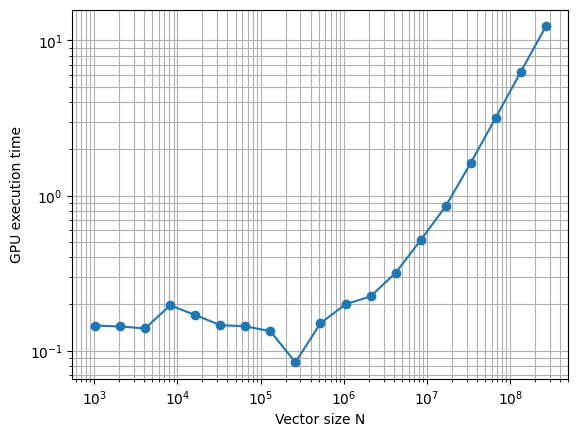

In [ ]:
import subprocess
import re
import matplotlib.pyplot as plt
import numpy as np

shifts = list(range(10, 29))
Ns = []
times = []

for s in shifts:
    result = subprocess.run(
        ["./vector_mul", str(s)],
        capture_output=True,
        text=True
    )

    output = result.stdout

    match_N = re.search(r"Vector size \(N\)\s+: (\d+)", output)
    match_time = re.search(r"Execution time\s+: ([0-9.]+)", output)

    if match_N and match_time:
        Ns.append(int(match_N.group(1)))
        times.append(float(match_time.group(1)))

Ns = np.array(Ns)
times = np.array(times)


plt.figure()
plt.loglog(Ns, times, marker='o')
plt.xlabel("Vector size N")
plt.ylabel("GPU execution time")
plt.title("Log-Log Scale: GPU Time vs Vector Size")
plt.grid(True, which="both")
plt.show()